In [1]:
import tensorflow as tf
import numpy as np
import os.path
import joblib
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, Add, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Imported the neccessary libraries 

2023-03-24 23:20:08.652783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 23:20:08.951023: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 23:20:08.982817: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-24 23:20:08.982847: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:

import os
import shutil
import glob
import random

def copy_files_70_30_percent():
    os.chdir(os.path.dirname(os.path.abspath('model_alzheimers_cnn.ipynb')))
    
    if os.path.isdir('model_data') is False:
        os.makedirs('model_data/train/axial/AD')
        os.makedirs('model_data/train/coronal/AD')
        os.makedirs('model_data/train/sagittal/AD')
        os.makedirs('model_data/train/axial/CN')
        os.makedirs('model_data/train/coronal/CN')
        os.makedirs('model_data/train/sagittal/CN')
        os.makedirs('model_data/train/axial/MCI')
        os.makedirs('model_data/train/coronal/MCI')
        os.makedirs('model_data/train/sagittal/MCI')
        os.makedirs('model_data/valid/axial/AD')
        os.makedirs('model_data/valid/coronal/AD')
        os.makedirs('model_data/valid/sagittal/AD')
        os.makedirs('model_data/valid/axial/CN')
        os.makedirs('model_data/valid/coronal/CN')
        os.makedirs('model_data/valid/sagittal/CN')
        os.makedirs('model_data/valid/axial/MCI')
        os.makedirs('model_data/valid/coronal/MCI')
        os.makedirs('model_data/valid/sagittal/MCI')
        
       # creates a directory named model_data and several subdirectories with different names and
        # paths representing the classes and image orientations used for training and validation of a machine learning model, 
        # if the model_data directory does not exist already.
        
        
        # get current directory
        print(os.getcwd())
        for view in ['axial', 'coronal', 'sagittal']:
            # os.chdir('../')
            all_ad_files = glob.glob(f'Processed_MRI/augmented/AD/{view}/*')
            all_cn_files = glob.glob(f'Processed_MRI/augmented/CN/{view}/*')
            all_mci_files = glob.glob(f'Processed_MRI/augmented/MCI/{view}/*')
            
            print(len(all_ad_files))

            num_ad_files = len(all_ad_files)
            num_cn_files = len(all_cn_files)
            num_mci_files = len(all_mci_files)

            num_ad_train = int(0.7 * num_ad_files)
            num_cn_train = int(0.7 * num_cn_files)
            num_mci_train = int(0.7 * num_mci_files)

            ad_train_files = random.sample(all_ad_files, num_ad_train)
            cn_train_files = random.sample(all_cn_files, num_cn_train)
            mci_train_files = random.sample(all_mci_files, num_mci_train)

            ad_valid_files = list(set(all_ad_files) - set(ad_train_files))
            cn_valid_files = list(set(all_cn_files) - set(cn_train_files))
            mci_valid_files = list(set(all_mci_files) - set(mci_train_files))

            # print(os.getcwd())
            # os.chdir('code')
            for c in ad_train_files:
                shutil.copy(c, f'model_data/train/{view}/AD')
            for c in cn_train_files:
                shutil.copy(c, f'model_data/train/{view}/CN')
            for c in mci_train_files:
                shutil.copy(c, f'model_data/train/{view}/MCI')

            for c in ad_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/AD')
            for c in cn_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/CN')
            for c in mci_valid_files:
                shutil.copy(c, f'model_data/valid/{view}/MCI')
                # copying files from different directories into specific train and validation directories based on their class labels (AD, CN, MCI) and image view.


In [3]:
copy_files_70_30_percent()

In [4]:
train_path = 'model_data/train/axial' 
valid_path = 'model_data/valid/axial'

## Use the vgg16 prepocesser to preprocess the images which resizes and reshapes the images to feed the model

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN'])
 
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10, classes=['AD', 'CN'], shuffle=False)

Found 695 images belonging to 2 classes.
Found 299 images belonging to 2 classes.


In [6]:
# assert train_batches.n == 1341
# assert valid_batches.n == 576

In [7]:
imgs, labels = next(train_batches)

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

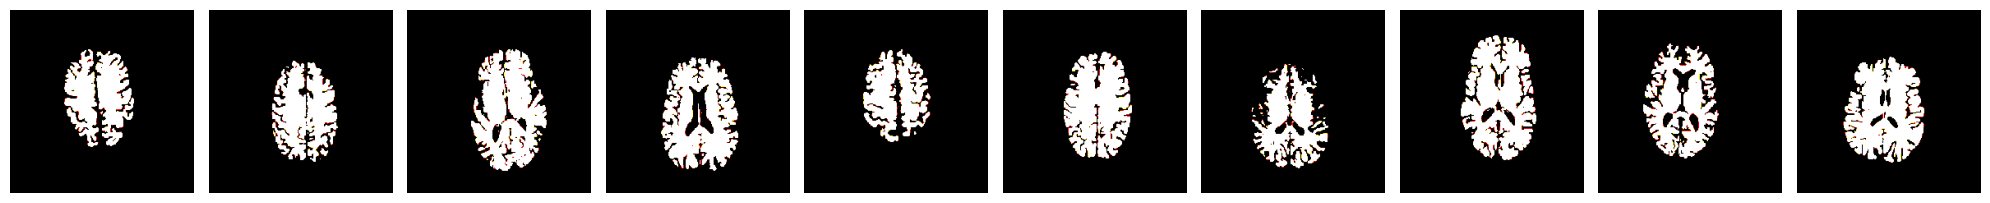

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)

## Filters

The higher the number of filters, the higher the number of abstractions that your Network is able to extract from image data. The reason why the number of filters is generally ascending is that at the input layer the Network receives raw pixel data. Raw data are always noisy, and this is especially true for image data.

Because of this, we let CNNs extract first some relevant information from noisy, "dirty" raw pixel data. Once the useful features have been extracted, then we make the CNN elaborate more complex abstractions on it.

That is why the number of filters usually increases as the Network gets deeper, even though it doesn't necessarily have to be like that.


## Kernel Size

Convolutional neural networks work on 2 assumptions -

Low level features are local
What's useful in one place will also be useful in other places
Kernel size should be determined by how strongly we believe in those assumptions for the problem at hand.

In one extreme case where we have 1x1 kernels, we are essentially saying low level features are per-pixel, and they don't affect neighbouring pixels at all, and that we should apply the same operation to all pixels.

In the other extreme, we have kernels the size of the entire image. In this case the CNN essentially becomes fully connected, and stops being a CNN, and we are no longer making any assumption on low level feature locality.

In [10]:
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(input_tensor)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
output_tensor = Dense(units=2, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

#a simple CNN model using Keras with an input layer, two convolutional layers, max pooling, dropout, and a softmax output layer.

2023-03-24 23:23:28.066385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-24 23:23:28.066437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (divya-Inspiron-15-5518): /proc/driver/nvidia/version does not exist
2023-03-24 23:23:28.073944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


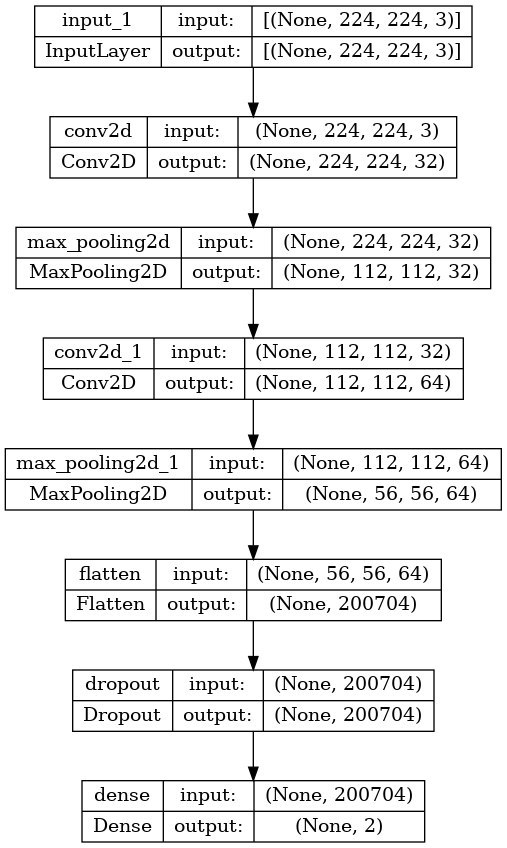

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='models/architecture_images/model_plot_simple_cnn_binary.png', show_shapes=True, show_layer_names=True)

#Plotting the architecture.

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0     

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
from keras.callbacks import LearningRateScheduler

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 20:
        lr *= 0.1
    return lr

if os.path.isfile('models/basic_model_binary.h5'):
    model = load_model('models/basic_model_binary.h5')
    history = joblib.load('models/history/basic_model_binary_history.pkl')
else:
    history = model.fit(x=train_batches, validation_data=valid_batches, epochs=50, verbose=2, callbacks=[callback, LearningRateScheduler(lr_schedule)])
    joblib.dump(history, 'models/history/basic_model_binary_history.pkl')
    
    model.save('models/basic_model_binary.h5')
    
    #defines an early stopping callback and a learning rate scheduler for a binary classification model. It then checks if a saved model exists 
    # and loads it along with its history if available, or else trains a new model and saves its history and model.

Epoch 1/50
70/70 - 14s - loss: 29.9703 - accuracy: 0.5597 - val_loss: 11.0591 - val_accuracy: 0.6388 - lr: 1.0000e-04 - 14s/epoch - 207ms/step
Epoch 2/50
70/70 - 12s - loss: 10.1683 - accuracy: 0.5799 - val_loss: 5.6884 - val_accuracy: 0.6656 - lr: 1.0000e-04 - 12s/epoch - 175ms/step
Epoch 3/50
70/70 - 12s - loss: 2.7288 - accuracy: 0.7281 - val_loss: 7.9593 - val_accuracy: 0.6087 - lr: 1.0000e-04 - 12s/epoch - 171ms/step
Epoch 4/50
70/70 - 13s - loss: 2.6223 - accuracy: 0.7453 - val_loss: 4.4210 - val_accuracy: 0.6154 - lr: 1.0000e-04 - 13s/epoch - 190ms/step
Epoch 5/50
70/70 - 14s - loss: 0.7124 - accuracy: 0.8820 - val_loss: 3.7934 - val_accuracy: 0.6488 - lr: 1.0000e-04 - 14s/epoch - 195ms/step
Epoch 6/50
70/70 - 13s - loss: 0.2800 - accuracy: 0.9396 - val_loss: 2.6541 - val_accuracy: 0.6923 - lr: 1.0000e-04 - 13s/epoch - 181ms/step
Epoch 7/50
70/70 - 13s - loss: 0.2518 - accuracy: 0.9424 - val_loss: 2.6632 - val_accuracy: 0.6656 - lr: 1.0000e-04 - 13s/epoch - 189ms/step
Epoch 8/50

# Tracking Convergence

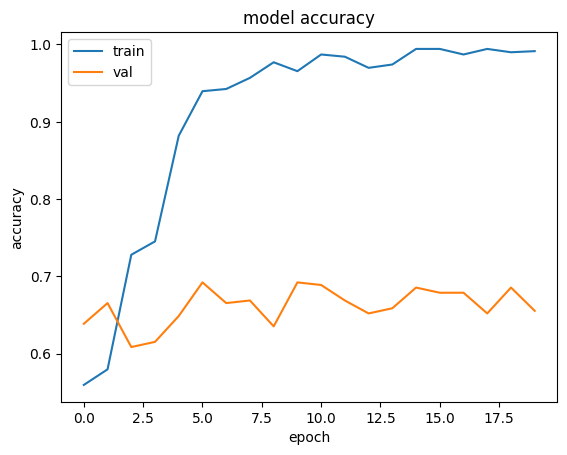

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#plot and visualize the training and validation accuracy of the model over epochs.

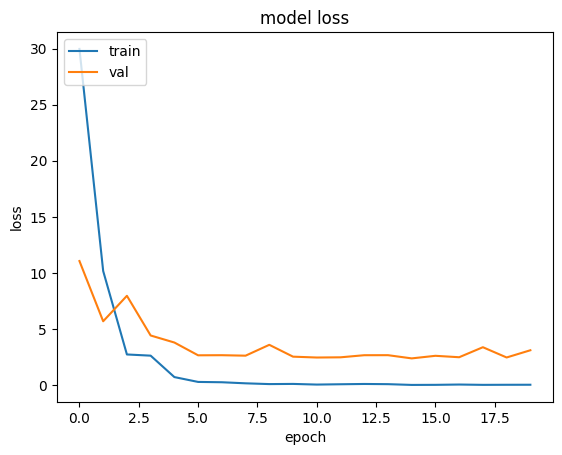

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Visualizes the training and validation loss of a model over epochs.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

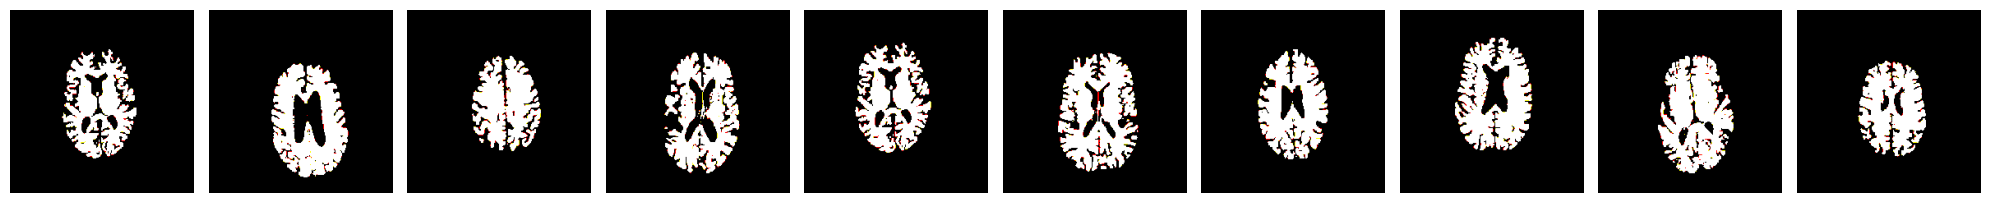

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [34]:
test_imgs, test_labels = next(valid_batches)
plotImages(test_imgs)
print(test_labels) 

#Displaying a batch of test images and their corresponding labels

In [35]:
predictions = model.predict(x=valid_batches, verbose=0)

#predictions on the validation data (valid_batches). The resulting predictions are stored in the predictions variable.

In [36]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [37]:
test_imgs, test_labels = next(valid_batches)

In [38]:
test_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [39]:
import os
from tensorflow.keras.preprocessing.image import load_img

# Get the list of file names in the directory
file_names_ad = os.listdir(train_path + "/AD")

# Select the first file name from the list
first_file_name = file_names_ad[0]

# Load the first image
ad = load_img(train_path + "/AD/" + first_file_name)

# Get the list of file names in the directory
file_names_cn = os.listdir(train_path + "/CN")

# Select the first file name from the list
first_file_name = file_names_cn[0]

# Load the first image
cn = load_img(train_path + "/CN/" + first_file_name)


In [40]:
# Preprocess the images using VGG16 preprocessing function
ad_processed = tf.keras.applications.vgg16.preprocess_input(np.array(ad.resize((224, 224))))
cn_processed = tf.keras.applications.vgg16.preprocess_input(np.array(cn.resize((224, 224))))

# Create a batch of size 2 with the processed images
visualize_batch = np.stack([ad_processed, cn_processed])


In [41]:
visualize_batch[0].shape

(224, 224, 3)

In [42]:
len(model.layers)

8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


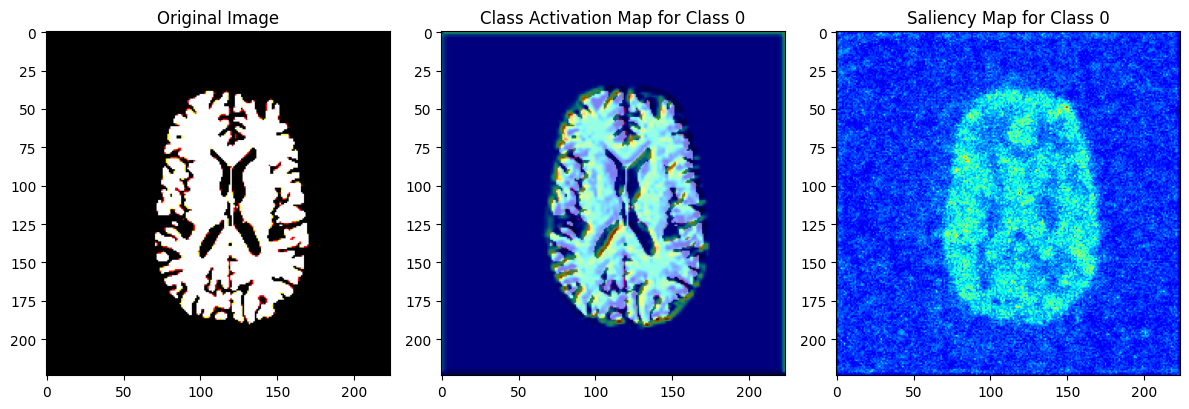

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


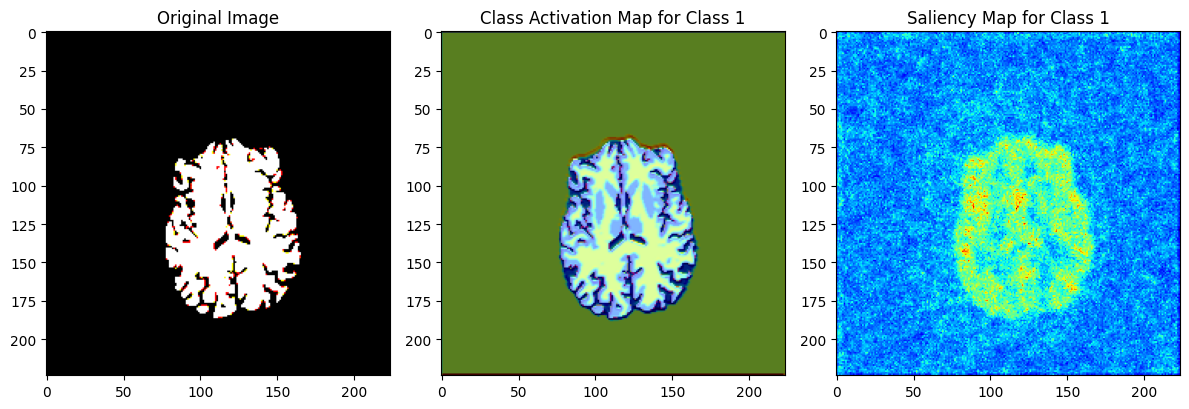

In [51]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam  #CAMs  highlight which parts of the image contributed most to the predicted class
from tf_keras_vis.saliency import Saliency
replace2linear = ReplaceToLinear()  # This is used to replace all activation functions in the model with linear activations.

# Select an image from the validation set

#Here we have used tensorflow keras visualisation library to generate heatmaps (Heat Maps are graphical representations of data that utilize color-coded systems) 
# of class activation maps (CAMs) and saliency maps for an image classification model
# Select an image from the validation set

batch = valid_batches
# gradcam_model = tf.keras.models.Model(
#     [model.inputs], [model.layers[-3].output, model.output]
# )
# Create GradCAM++ object  #GradCAM++ is an extension of GradCAM that improves the visualization quality of GradCAM.
# Create Gradcam object
gradcam = GradcamPlusPlus(model,
                  model_modifier=replace2linear,
                  
                  clone=True)

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map (saliency maps highlight which pixels contributed most to the prediction.)


# Loop over all classes and generate corresponding heatmaps
for class_index in range(len(valid_batches.class_indices)):
    # error = True
    image = visualize_batch[class_index]
    mapping = {
        0: 3,
        1: 1
    }
    # Generate cam with GradCAM++
    cam = gradcam(CategoricalScore(class_index), image, penultimate_layer=mapping[class_index])
    saliency_map = saliency(CategoricalScore(class_index), image, smooth_samples=20, smooth_noise=0.20) # noise spread level.)
    
    # Plot the original image and the heatmap
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title('Original Image')
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    axs[1].imshow(image)
    axs[1].imshow(heatmap, alpha=0.5, cmap='jet')
    axs[1].set_title(f'Class Activation Map for Class {class_index}')
    
    axs[2].imshow(saliency_map[0], cmap='jet')
    axs[2].set_title(f'Saliency Map for Class {class_index}')
    plt.tight_layout()
    plt.show()

#visualize which parts of an image the model is paying attention to when making its predictions. 
# It does so by generating heatmaps of the CAMs and saliency maps. 


In [44]:
cm = confusion_matrix(y_true=valid_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [45]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}%".format(cm[i, j] * 100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    #plotting a confusion matrix with optional normalization and percentage values for each cell in the matrix. The cm variable contains the confusion matrix,
    # classes is a list of the class labels, 
    # and title is the title of the plot. The function also sets the labels for the x-axis and y-axis and displays a colorbar.

In [46]:
valid_batches.class_indices

{'AD': 0, 'CN': 1}

Confusion matrix for the model is shown below, where the diagonal elements are the true positives, the off-diagonal elements are the false positives.

Normalized confusion matrix
[[0.512      0.488     ]
 [0.18965517 0.81034483]]


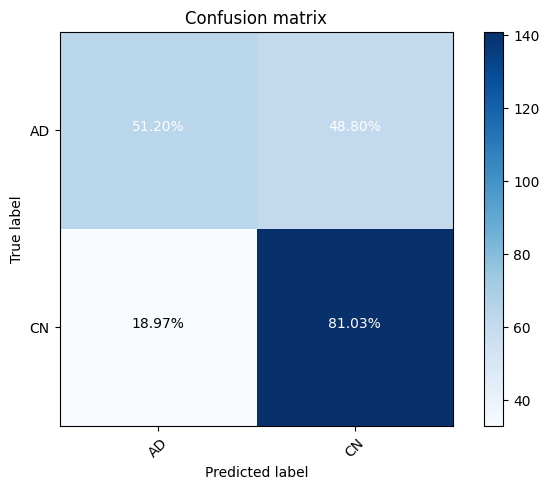

In [47]:
cm_plot_labels = valid_batches.class_indices.keys()
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion matrix', normalize= True)

#plotting the confusion matrix

In [48]:
from sklearn import metrics

print(metrics.classification_report(valid_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

##generating a report which includes various metrics such as precision, recall, f1-score, and support for each class. 

              precision    recall  f1-score   support

          AD       0.66      0.51      0.58       125
          CN       0.70      0.81      0.75       174

    accuracy                           0.69       299
   macro avg       0.68      0.66      0.66       299
weighted avg       0.68      0.69      0.68       299

